# Computing Depth Maps

Progress: 1/204
Progress: 2/204
Progress: 3/204
Progress: 4/204
Progress: 5/204
Progress: 6/204
Progress: 7/204
Progress: 8/204
Progress: 9/204
Progress: 10/204
Progress: 11/204
Progress: 12/204
Progress: 13/204
Progress: 14/204
Progress: 15/204
Progress: 16/204
Progress: 17/204
Progress: 18/204
Progress: 19/204
Progress: 20/204
Progress: 21/204
Progress: 22/204
Progress: 23/204
Progress: 24/204
Progress: 25/204
Progress: 26/204
Progress: 27/204
Progress: 28/204
Progress: 29/204
Progress: 30/204
Progress: 31/204
Progress: 32/204
Progress: 33/204
Progress: 34/204
Progress: 35/204
Progress: 36/204
Progress: 37/204
Progress: 38/204
Progress: 39/204
Progress: 40/204
Progress: 41/204
Progress: 42/204
Progress: 43/204
Progress: 44/204
Progress: 45/204
Progress: 46/204
Progress: 47/204
Progress: 48/204
Progress: 49/204
Progress: 50/204
Progress: 51/204
Progress: 52/204
Progress: 53/204
Progress: 54/204
Progress: 55/204
Progress: 56/204
Progress: 57/204
Progress: 58/204
Progress: 59/204
Progre

Text(0.5, 1.0, 'Depth Map (SSD)')

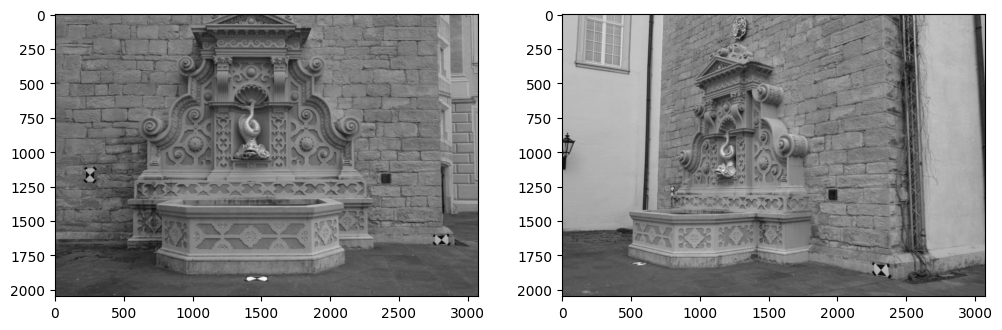

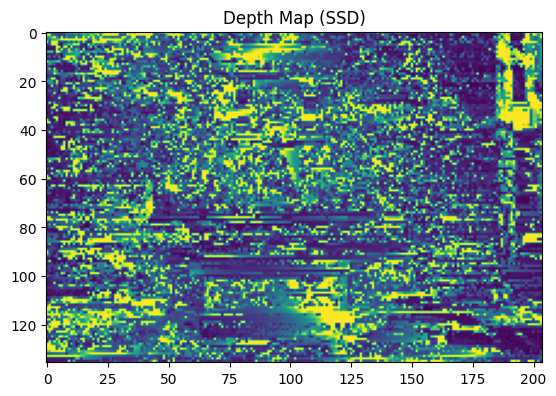

In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import scipy.signal
import cv2
import time

# Load the images
def load_image_gray(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(float)/255
    if len(img.shape) > 2:
        return img[:, :, 0]
    else:
        return img
    
# Get image patches
def get_patch(image, x, y, patch_half_width):
    return image[y-patch_half_width:y+patch_half_width+1,
                 x-patch_half_width:x+patch_half_width+1]

def compute_match_score_ssd(patch_a, patch_b):
    """Note: this score will be negative, since you are looking for the 'minimum',
    but the patch_match_stereo function relies on 'argmax'."""
    return -np.sum((patch_a - patch_b) ** 2)

def patch_match_stereo(image_a, image_b, x_a, y_a,
                       match_score_fn,
                       patch_half_width=9):
    """Returns the location of a feature/patch between stereo images.
    Inputs are the x, y coordinates of the patch in image_a.
    Outputs are the x, y coordinates of the patch in image_b."""

    # (1) Get the patch in image a
    patch_a = get_patch(image_a, x_a, y_a, 
                        patch_half_width=patch_half_width)
    
    # (2) Compute the responses along the epipolar line in image b
    # Define the possible coordinates along with the match might be found
    # (You should feel free to modify this code if you have a simpler
    # way to represent this operation.)
    possible_coordinates = None
    xs = range(patch_half_width, image_b.shape[1]-patch_half_width)
    ys = [y_a] * len(xs)
    possible_coordinates = list(zip(xs, ys))
    if possible_coordinates is None:
        raise NotImplementedError()

    response = np.zeros((len(possible_coordinates)))
    for ind, (x_b, y_b) in enumerate(possible_coordinates):
        # Get the patch
        patch_b = get_patch(image_b, x_b, y_b,
                            patch_half_width=patch_half_width)
        # Compute the match score & store
        response[ind] = match_score_fn(patch_a, patch_b)
    
    # (3) Compute the maximum response
    ind = np.argmax(response)
    x_b, y_b = possible_coordinates[ind]

    return x_b, y_b, response[ind]

def compute_depth_map(image_a, images, match_score_fn, phw=8, spacing=15):
    stime = time.time()
    similarities = []
    for i,image_b in enumerate(images):
        xs = range(phw, (image_b.shape[1]-phw), spacing)
        ys = range(phw, (image_b.shape[0]-phw), spacing)
        disparity_mat = np.zeros((len(ys), len(xs)))
        responses_mat = np.zeros((len(ys), len(xs)))
        for xi, x_a in enumerate(xs):
            print(f"Progress: {xi+1}/{len(xs)}")
            for yi, y_a in enumerate(ys):
                x_b, y_b, response = patch_match_stereo(
                    image_a, image_b, x_a, y_a, match_score_fn, patch_half_width=phw)
                dx = x_a - x_b
                dy = y_a - y_b
                disparity_mat[yi, xi] = np.sqrt(dx**2 + dy**2)
                responses_mat[yi, xi] = response
        similarities.append(disparity_mat)
    
    final_disparities = np.zeros((len(similarities[0]), len(similarities[0][0])))
    for row in range(len(final_disparities)):
        for col in range(len(final_disparities[row])):
            values = [arr[row,col] for arr in similarities]
            final_disparities[row][col] = np.min(values)
    # Compute and threshold the depth map
    depth = 1/(final_disparities.copy() + 1e-5)
    depth[depth > 0.01] = 0.01
    
    print(f"Time took: {time.time() - stime}")
    return depth



"""
Implemention of the Zero Normalized Cross Correlation algorithm
for computing depth map

Parameters
----------
patch_a: first image patch
patch_b: second image patch

Returns
----------
z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

"""

def compute_match_score_zncc(patch_a, patch_b):
    # Compute mean of each patch
    mean_a = np.mean(patch_a)
    mean_b = np.mean(patch_b)

    
    # Compute normalized cross-correlation
    numerator = np.sum((patch_a - mean_a) * (patch_b - mean_b))
    sigmas = np.sqrt(np.sum((patch_a - mean_a)**2)) * np.sqrt(np.sum((patch_b - mean_b)**2))
    
    if sigmas == 0:  # Avoid division by zero
        return 0.0
    else:
        zncc = numerator / sigmas
        return zncc    
    
image_a = load_image_gray('fountain_dense_images/0005.png')
image_b = load_image_gray('fountain_dense_images/0000.png')
image_c = load_image_gray('fountain_dense_images/0007.png')

plt.figure(figsize=(12, 5))
ax_a = plt.subplot(1, 2, 1)
plt.imshow(image_a, cmap='gray')
ax_b = plt.subplot(1, 2, 2)
plt.imshow(image_b, cmap='gray')

plt.figure()
plt.imshow(compute_depth_map(image_a, [image_b,image_c], compute_match_score_ssd))
plt.title('Depth Map (SSD)')

In [ ]:
# load static parameters manually

# load intrinsic camera matrices
ip = np.array([[2759.48, 0,       1520.69],
               [0,       2764.16, 1006.81],
               [0,       0,       1      ]])


# load external parameters of camera
ep_10 = np.array([[0.70735,   0.706534,   0.0215749 ],
                  [0.0218279, -0.0523403, 0.998391  ],
                  [0.706526,  -0.705741 , -0.0524451]])
ep_09 = np.array([[0.84137,    0.540262,   0.0145864 ],
                  [0.00860137, -0.0403709, 0.999148  ],
                  [0.540391,   -0.840528,  -0.0386139]])
ep_08 = np.array([[0.928942,    0.370116,   0.00895096 ],
                  [0.000956298, -0.0265758, 0.999646   ],
                  [0.370223,    -0.928605,  -0.0250414 ]]) 
ep_07 = np.array([[0.995535,   0.0943815, -0.00170578],
                  [0.003721,  -0.02118,   0.999769   ],
                  [0.0943235, -0.995311,  -0.0214366 ]])
ep_06 = np.array([[0.994915,    -0.100715,  0.00117536],
                  [-0.00462005, -0.0339759, 0.999412  ],
                  [-0.100616,   -0.994335,  -0.0342684]])
ep_05 = np.array([[0.962742,   -0.270399,  0.00344709],
                  [-0.0160548, -0.0444283, 0.998884  ],
                  [-0.269944,  -0.961723,  -0.0471142]])
ep_04 = np.array([[0.890856,   -0.454283,  -0.00158434],
                  [-0.0211638, -0.0449857, 0.998763   ],
                  [-0.453793,  -0.889721,  -0.0496901 ]])
ep_03 = np.array([[0.795163,  -0.606377,  -0.00477103],
                  [-0.050195, -0.0736593, 0.996019   ],
                  [-0.604314, -0.791759,  -0.0890082 ]])
ep_02 = np.array([[0.666779,   -0.74495,   0.021334  ],
                  [-0.0831384, -0.0459057, 0.99548   ],
                  [-0.740603,  -0.665539 , -0.0925429]])
ep_01 = np.array([[0.582226,   -0.813027,  -0.000148752],
                  [-0.0983866, -0.0706383, 0.992638    ],
                  [-0.807052,  -0.577925,  -0.121118   ]])
ep_00 = np.array([[0.450927,   -0.892535,  0.00679989],
                  [-0.0945642, -0.0401974, 0.994707  ],
                  [-0.887537,  -0.449183 , -0.102528 ]])

# load camera positions
cmpos_10 = np.array([-21.9937, -5.82033, -0.0463931])
cmpos_09 = np.array([-20.9553, -4.61897, -0.0303931])
cmpos_08 = np.array([-19.6309, -3.81958, -0.00781603])
cmpos_07 = np.array([-17.6302, -3.36186, 0.0325247])
cmpos_06 = np.array([-15.8818, -3.15083, 0.0592619])
cmpos_05 = np.array([-14.1604, -3.32084, 0.0862032])
cmpos_04 = np.array([-12.404,  -3.81315, 0.110559 ])
cmpos_03 = np.array([-10.8142, -4.53704, 0.122293 ])
cmpos_02 = np.array([-9.46627, -5.58174, 0.147736 ])
cmpos_01 = np.array([-8.31326, -6.3181,  0.16107  ])
cmpos_00 = np.array([-7.28137, -7.57667, 0.204446 ])

# load picture resolution
resolution = (3072, 2048)

# load 3D bounds
bound_10 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_09 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_08 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_07 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound above
bound_06 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_05 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_04 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound below
bound_03 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_02 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_01 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
bound_00 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))

# cord for testing
cord = (-15.0744, -11.9719, -1.79769)

In [ ]:
#load images

img0 = load_image_gray('fountain_dense_images/0000.png')
img1 = load_image_gray('fountain_dense_images/0001.png')
img2 = load_image_gray('fountain_dense_images/0002.png')
img3 = load_image_gray('fountain_dense_images/0003.png')
img4 = load_image_gray('fountain_dense_images/0004.png')
img5 = load_image_gray('fountain_dense_images/0005.png')
img6 = load_image_gray('fountain_dense_images/0006.png')
img7 = load_image_gray('fountain_dense_images/0007.png')
img8 = load_image_gray('fountain_dense_images/0008.png')
img9 = load_image_gray('fountain_dense_images/0009.png')
img10 = load_image_gray('fountain_dense_images/0010.png')